# Вариант 10.В

Обобщенное распределение Лапласа со следующим значением параметра $n=4$.

$$
f(x,n) = f(x,4) = \frac{e^{-|x|}}{(n-1)!\cdot 16} \sum\limits_{j=0}^{3}\frac{(3+j)!}{(3-j)!\cdot j!} \frac{|x|^{3-j}}{2^{j}} = \
$$

$$
\ = e^{-|x|}\cdot\frac{|x|^{3}+6|x|^{2} + 15|x| + 15}{96}.
$$

Дисперсия: $\sigma^{2}= 8$,

Коэффициент эксцесса: $\large\gamma_{2} = \frac{3}{4}$. 


In [49]:
# базовые импорты

import math
import statistics
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline

import numpy as np

from scipy import stats as st
from scipy import integrate
from scipy.integrate import quad
from scipy.optimize import minimize

import pandas as pd

# Глобальные параметры
kol_rand = 800000  # количество которое хочешь сгенерить
eps = 0.1  # Эпсилон (коэффициент зашумления)
rng = np.random.default_rng(
    12345
)  # Генератор рандомных чисел с фиксированным сидом (для повторяемости результатов)

# Параметры для чистого распределения

N_net = 4  # Параметр распределения
l_net = 1  # Масштаб (лямбда)
O_net = 0  # Смещение (Тетта)
disp_net = 2 * N_net  # Дисперсия
excesses_net = 3 / N_net  # Эксцесс

# Параметры для шума

N_scatterer = N_net  # Параметр распределения
l_scatterer = 1  # Масштаб (лямбда). 1 по умолчанию
O_scatterer = 10  # Смещение (Тетта). 0 по умолчанию
disp_scatterer = 2 * N_scatterer * l_scatterer**2  # Дисперсия
excesses_scatterer = 3 / N_scatterer  # Эксцесс

## 1. Разработка программы

### 1.1. Генерация данных

> Полное задание пункта
> Разработать программу, которая реализует генерацию наборов данных с заданным в варианте *чистым распределением и засоренным распределением*, использовать засоряющие распределения, совпадающие с чистым с точностью до значений параметров сдвига и масштаба.

#### Генерация чистого распределения

Обобщённое распределение Лапласа с параметром $n=4$ задаётся следующим образом:

$$
f(x) = e^{-|x|}\cdot\frac{|x|^{3}+6|x|^{2} + 15|x| + 15}{96}.
$$

Дисперсия при этом равна $\sigma^{2}=8$, коэффициент эксцесса: $\large\gamma_{2}=\frac{3}{4}$.

Моделирование случайных величин осуществляется по следующей формуле:

$$
x = \ln\left(\frac{\prod\limits_{i:r_{i} \leqslant \frac{1}{2}} 2r_{i}}{\prod\limits_{i: r_{i} > \frac{1}{2}}2(1-r_{i})}\right),
$$

где $r_{i}, i=\{1, \dots, n\}= \{1,2,3,4\}$ – *реализация случайной величины*, равномерно распределённой на интервале $(0; 1)$ (просто 4 значения с генератора равномерных случайных чисел); если нет ни одного элемента, удовлетворяющего условию в произведении, то оно равно 1.

#### Генерация засоряющего распределения

Засоряющее распределение должно (судя по всему) повторять исходное распределение, но также должно иметь возможность изменять свой масштаб и сдвиг.  Сдвиг-масштабное преобразование осуществляется по следующей формуле:

$$
x = \theta + \lambda x_{1},
$$

где $\theta$ – параметр сдвига, $\lambda$ – параметр масштаба, $x_{1}$ – значение случайной величины с нулевым сдвигом и единичным масштабом. 

Применимо к формуле нашего распределения, получаем:

$$
x = \theta + \lambda \ln\left(\frac{\prod\limits_{i:r_{i} \leqslant \frac{1}{2}} 2r_{i}}{\prod\limits_{i: r_{i} > \frac{1}{2}}2(1-r_{i})}\right).
$$



In [50]:
def gen_rand_laplas(n_lap: int, theta: float = 0.0, lamb: float = 1.0) -> float:
    """
    Генератор случайной величины, соответствующей обобщенному распределению Лапласа, с возможностью задания сдвига и масштабирования

    Args:
        n_lap (int): Натуральное число, соответствющее количеству случайных величин. Является параметром обобщённого распределения Лапласа `n`
        theta (float, optional): параметр сдвига распределения тэтта. По умолчанию 0.0
        lamb (float, optional): параметр масштабироваиня сдвига лямбда. По умолчанию 1.0

    Returns:
        float: Случайная величина, соответствующая обобщенному распределению Лапласа.
    """
    global rng

    list_rand = rng.random((n_lap,))

    res = 1.0
    for item in list_rand:
        if item <= (1 / 2):
            res *= 2 * item
        else:
            res /= 2 * (1 - item)

    return np.log(res) * lamb + theta


def gen_full_laplas(
    count: int, theta: float = 0.0, lamb: float = 1.0
) -> np.ndarray[np.float64]:
    """Генератор множества случайных величин по распределению Лапласа

    Args:
        count (int): размер выборки случайных чисел по данному распределению
        theta (float, optional): параметр сдвига распределения тэтта. По умолчанию 0.0
        lamb (float, optional): параметр масштабироваиня сдвига лямбда. По умолчанию 1.0

    Returns:
        ndarray[float64]: множество значений полученной выборки
    """
    global N_net

    res = [gen_rand_laplas(N_net, theta=theta, lamb=lamb) for _ in range(count)]
    return np.asarray(res)

print(f"Размер выборки: {kol_rand} элементов...")

print("Строим чистое распределение...")
clean = gen_full_laplas(kol_rand)

print("Строим загрязняющее распределение...")
scattener = gen_full_laplas(kol_rand, theta=O_scatterer)

Размер выборки: 800000 элементов...
Строим чистое распределение...
Строим загрязняющее распределение...


#### Генерация засорённого распределения

Засорённое распределение представляет собой смесь двух распределений с плотностью, задаваемой следующей формулой:

$$
g(x) = (1 - \varepsilon) f(x) + \varepsilon h(x),
$$

где $0 < \varepsilon < 0.5$ – уровень засорения, $f(x), h(x)$ – плотности чистого и засоряющего распределений соответственно.

Моделирование случайной величины с засорённым распределением можно проводить по следующему алгоритму:

1. Сгенерировать случайное число $r$, равномерно распределённое на интервале $(0; 1)$. Если $r \leqslant 1 - \varepsilon$, перейти на шаг 2, иначе перейти на шаг 3.
2. Сгенерировать случайное число с плотностью $f(x)$ (чистое распределение). Оно и будет искомым числом.
3. Сгенерировать случайное число с плотностью $h(x)$ (загрязняющее распределение). Оно и будет искомым числом.

In [51]:
def get_scattened_laplas(
    clean: np.ndarray[np.float64], scattener: np.ndarray[np.float64], eps: float
) -> np.ndarray[np.float64]:
    """Соединяет чистое и загрязняющее распределения в единое загрязнённое

    Args:
        clean (np.ndarray[np.float64]): множество случайных величин из чистого распределения
        scattener (np.ndarray[np.float64]): множество случайных величин из загрязняющего распределения (должно совпадать по размеру с чистым)
        eps (float): коэффициент загрязнения (0 <= `eps` <= 0.5)

    Returns:
        np.ndarray[np.float64]: полученное загрязнённое распределение
    """
    global rng
    res = np.zeros_like(clean)
    rand = rng.random((clean.size,))

    for ind in range(res.size):
        if rand[ind] <= (1 - eps):
            res[ind] = clean[ind]
        else:
            res[ind] = scattener[ind]

    return res

scattened = get_scattened_laplas(clean, scattener, eps)

Графики функций плотности полученных распределений


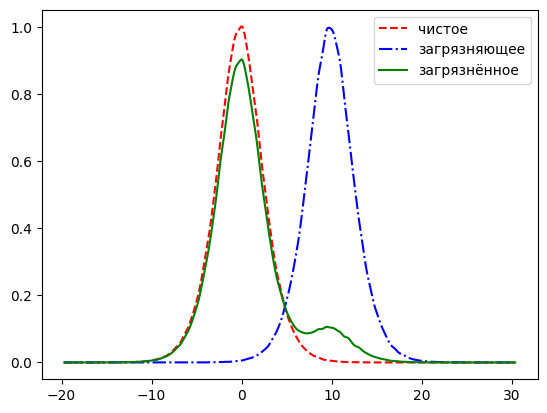

In [57]:
def ploat_graphics(
    clean: np.ndarray[np.float64],
    scattener: np.ndarray[np.float64],
    scattened: np.ndarray[np.float64],
):
    """Выводит графики сгенерированных распределений на экран (приводя размеры к единичному по графику `clean`)

    Args:
        clean (np.ndarray[np.float64]): массив значений из чистого распределения
        scattener (np.ndarray[np.float64]): массив значений из загрязняющего распределения
        scattened (np.ndarray[np.float64]): массив значений из грязного распределения
    """
    # Сгруппировать данные и просуммировать их по группам
    count_of_groups = 125
    lowest_value = min(clean.min(), scattener.min(), scattened.min())
    highest_value = max(clean.max(), scattener.max(), scattened.max()) + 1

    x_values = np.linspace(lowest_value, highest_value, count_of_groups)
    clean_y = np.zeros_like(x_values)
    scattener_y = np.zeros_like(x_values)
    scattened_y = np.zeros_like(x_values)

    clean.sort()
    scattener.sort()
    scattened.sort()

    i = 1
    j = 0
    while j < clean.size:
        if clean[j] <= x_values[i]:
            clean_y[i - 1] += 1
            j += 1
        else:
            i += 1

    i = 1
    j = 0
    while j < scattener.size:
        if scattener[j] <= x_values[i]:
            scattener_y[i - 1] += 1
            j += 1
        else:
            i += 1

    i = 1
    j = 0
    while j < scattened.size:
        if scattened[j] <= x_values[i]:
            scattened_y[i - 1] += 1
            j += 1
        else:
            i += 1

    # Провести масштабирование графиков
    max_y = clean_y.max()
    clean_y = clean_y / max_y
    scattener_y = scattener_y / max_y
    scattened_y = scattened_y / max_y

    # Интерполируем графики в сплайны
    clean_spline = make_interp_spline(x_values, clean_y)
    scattener_spline = make_interp_spline(x_values, scattener_y)
    scattened_spline = make_interp_spline(x_values, scattened_y)

    X_ = np.linspace(x_values.min(), x_values.max(), 1000)

    cl_smooth = clean_spline(X_)
    scer_smooth = scattener_spline(X_)
    sced_smooth = scattened_spline(X_)

    # Выводим полученные графики
    fig, axes = plt.subplots()
    axes.plot(X_, cl_smooth, label="чистое", linestyle="--", color="red")
    axes.plot(X_, scer_smooth, label="загрязняющее", linestyle="-.", color="blue")
    axes.plot(X_, sced_smooth, label="загрязнённое", linestyle="-", color="green")
    # axes.plot([10.0, 10.0], [0.0, 1.1], label="Центр", color="purple")
    axes.legend()

    plt.show()

print("Графики функций плотности полученных распределений")
ploat_graphics(clean, scattener, scattened)

### 1.4. Вычисление математического ожидания, дисперсии, коэффициентов асимметрии и эксцесса случайной величины с засоренным распределением по заданным характеристикам чистого и засоряющего распределений

Для того, чтобы получить значения данных характеристик для загрязнённого распределения, надо найти их для чистого и загрязняющего. Ищуются они по следующим формулам:

$$
M = 0 + \theta,
$$

$$
D = \sigma^{2} = 2\cdot n \cdot \lambda^{2},
$$

$$
\gamma_{1} = 0, ???
$$

$$
\gamma_{2} = \frac{3}{n}.
$$


In [53]:
dataframe_labels = [
    "Мат ожидание М",
    "Дисперсия D",
    "Ассиметрия gamma_1",
    "Эксцесс gamma_2",
]

M1_ = 0 + O_net
D1_ = 2 * N_net * l_net**2
G11_ = 0
G12_ = 3 / N_net

print("Для чистого распределения:")
pd.DataFrame(np.array([dataframe_labels, [M1_, D1_, G11_, G12_]]).T, columns=["Параметр чистого", "Значение"])

Для чистого распределения:


,Параметр чистого,Значение
0,Мат ожидание М,0
1,Дисперсия D,8
2,Ассиметрия gamma_1,0
3,Эксцесс gamma_2,0.75


In [54]:
M2_ = 0 + O_scatterer
D2_ = 2 * N_scatterer * l_scatterer**2
G21_ = 0
G22_ = 3 / N_scatterer

print("Для загрязняющего распределения:")
pd.DataFrame(np.array([dataframe_labels, [M2_, D2_, G21_, G22_]]).T, columns=["Параметр загрязняющего", "Значение"])

Для загрязняющего распределения:


,Параметр загрязняющего,Значение
0,Мат ожидание М,10
1,Дисперсия D,8
2,Ассиметрия gamma_1,0
3,Эксцесс gamma_2,0.75


Для вычисления всяких там параметров полученного засорённого распределения можно воспользоваться следующими формулами. Обозначим $M_{i}, D_{i}, \gamma_{2i}, i=1,2$ мат ожидание, дисперсию и коэффициент эксцесса, соответствующие при $i=1$ и $i=2$ плотностям $f(x)$ и $h(x)$. Тогда матожидание, дисперсия, коэффициенты асимметрии и эксцесса случайной величины с засорённым распределением выражается формулами:

$$
M = (1-\varepsilon)M_{1} + \varepsilon M_{2},
$$

$$
D = (1 - \varepsilon)(M_{1}^{2} + D_{1}) + \varepsilon(M_{2}^{2} + D_{2}) - M^{2},
$$

$$
\gamma_{1} = \frac{1}{D^{1.5}} \left[(1 - \varepsilon) \left\{(M_{1} - M)^{3} + 3(M_{1} - M)D_{1}\right\} + \varepsilon \left\{(M_{2}-M)^{3} + 3(M_{2}-M)D_{2} \right\} \right],
$$

$$
\gamma_{2} = \frac{1}{D^{2}} \left\{ (1-\varepsilon) \left[ (M_{1} - M)^{4} + 6(M_{1} - M)^{2}D_{1} + D_{1}^{2}(\gamma_{21} + 3) \right] + \ \right.
$$

$$
\ + \left. \varepsilon [(M_{2}-M)^{4} +6(M_{2}-M)^{2}D_{2} + D_{2}^{2}(\gamma_{22} + 3) ] \right\} - 3.
$$

In [55]:
M_ = (1 - eps) * M1_ + eps * M2_
D_ = (1 - eps) * (M1_**2 + D1_) + eps * (M2_**2 + D2_) - M_**2
G1_ = (1 / D_**1.5) * (
    (1 - eps) * ((M1_ - M_) ** 3 + 3 * (M1_ - M_) * D1_)
    + eps * ((M2_ - M_) ** 3 + 3 * (M2_ - M_) * D2_)
)
G2_ = (1 / D_**2) * (
    (1 - eps) * ((M1_ - M_) ** 4 + 6 * (M1_ - M_) ** 2 * D1_ + D1_**2 * (G21_ + 3))
    + eps * ((M2_ - M_) ** 4 + 6 * (M2_ - M_) ** 2 * D2_ + D2_**2 * (G22_ + 3))
) - 3

print("Для загрязнённого распределения:")
pd.DataFrame(
    np.array([dataframe_labels, [M_, D_, G1_, G2_]]).T,
    columns=["Параметр загрязнённого", "Значение"],
)

Для загрязнённого распределения:


,Параметр загрязнённого,Значение
0,Мат ожидание М,1.0
1,Дисперсия D,17.0
2,Ассиметрия gamma_1,1.027209706036234
3,Эксцесс gamma_2,1.4491349480968863


### 1.2. Вычисление выборочных характеристик полученных распределений

